# Raman spectroscopic data analysis

Install missing dependencies

(when using Colab or running locally, you can copy only this file and clone the repo by uncommenting the first rows in the cell) 

In [1]:
#!git clone https://git.photonicdata.science/shuxia.guo/chemometrics-seminar

 #import os
 #os.chdir("tutorial_spec")

!pip install -q -r requirements.txt

Get citations for used packages (remove "#" to run)

In [2]:
#!pip show pandas numpy scikit-learn scipy matplotlib plotly

Load required dependencies

In [3]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score
import matplotlib.pyplot as plt
import plotly.express as px
from custom_classes import SpectralData, ImportData

# Raman spectroscopic imaging
Load data

In [16]:
data_loader = ImportData("data/Scan.zip")
scan_wn, scan_mat, scan_shape = data_loader.parse_zip_scan()

scan_spec = SpectralData(x=scan_wn, y=scan_mat)

Spectral matrix shape: (13000, 1024)
Wavenumber axis length: 1024, min: 249.863838, max: 3451.80942


Plot raw data

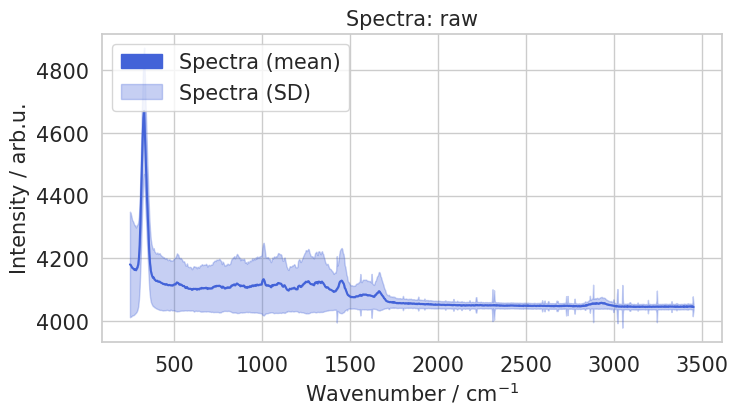

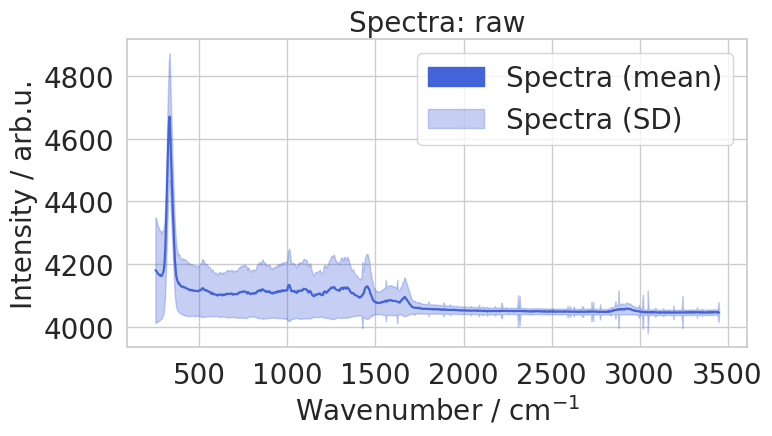

In [12]:
scan_spec.plot(fontsize=15, legend_loc='upper left')   # plot with default parameters
scan_spec.plot(fontsize= 20 , legend_loc='upper right')  # plot with customized parameters

Preprocess spectra using the documentation on SpectralData class
https://oleg.pages.photonicdata.science/tutorial_spec/docs/custom_classes.html#custom_classes.SpectralData

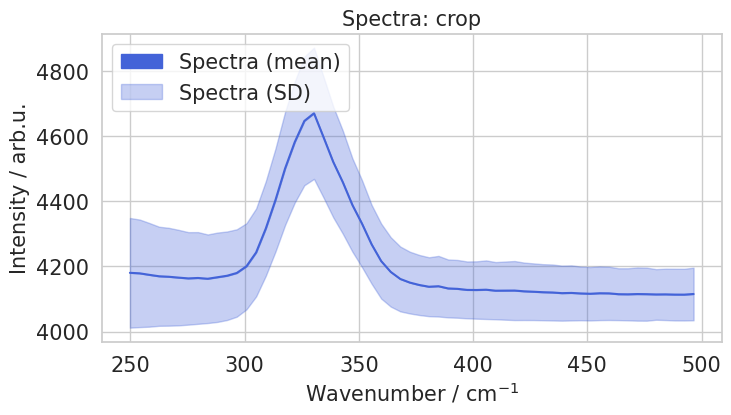

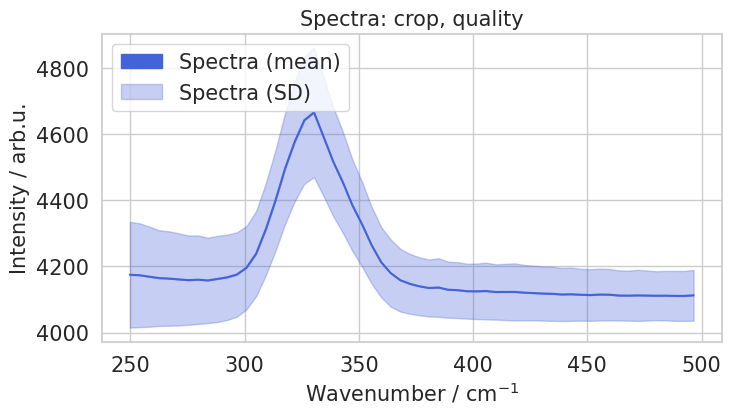

In [13]:
scan_spec.crop(ranges_list=[( 200 , 500 )])
scan_spec.plot()

# Baseline correction (AsLS)
scan_spec.quality_corr()

scan_spec.plot()

# Vector normalization
scan_spec.normalize(method="vector")

List the preprocessing steps

In [14]:
scan_spec.get_steps()

,step,method,args
0,crop,include_endpoints,"{'ranges': [(200, 500)]}"
1,quality,correlation,"{'threshold': 0.95, 'ref': [4180.335230769231,..."
2,normalization,vector,{}


Do PCA

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_481/19936718.py:9: SyntaxWarning: invalid escape sequence '\m'
  xlabel='Wavenumber / $\mathregular{cm^{-1}}$')


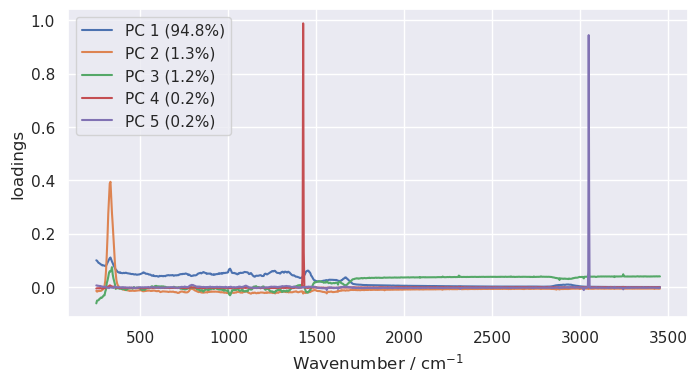

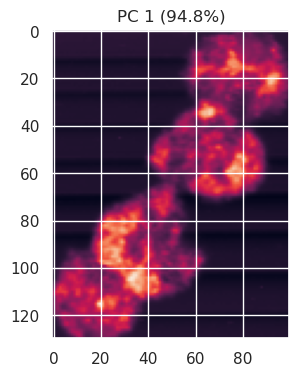

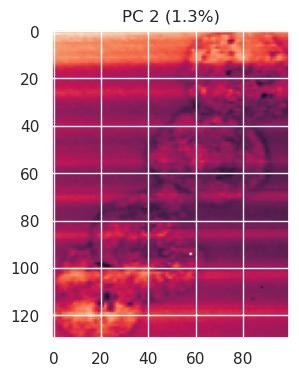

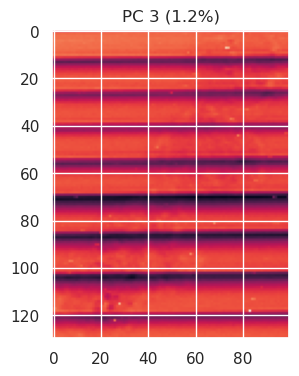

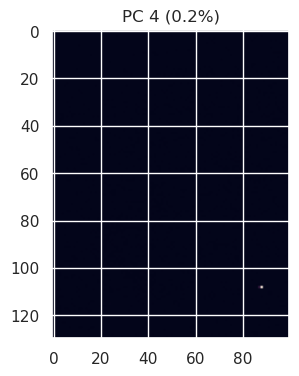

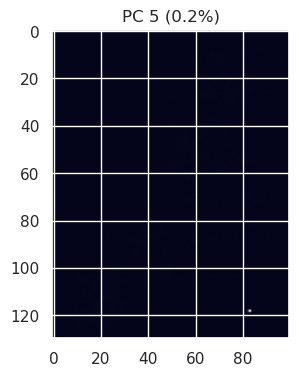

In [17]:
scan_pca_model = PCA(n_components=50)   # set maximal number of PC here
scan_pc_mat = scan_pca_model.fit_transform(scan_spec.y)
scan_pc_labels = {str(i): f"PC {i+1} ({var:.1f}%)"
                  for i, var in enumerate(scan_pca_model.explained_variance_ratio_ * 100)}
ncomp_plot = 5
scan_pc_loadings = {list(scan_pc_labels.values())[i]: scan_pca_model.components_[i] for i in range(ncomp_plot)}
scan_pc_loadings["wn"] = scan_spec.x
pd.DataFrame(scan_pc_loadings).plot(x="wn", ylabel="loadings",
                                    xlabel='Wavenumber / $\mathregular{cm^{-1}}$')
plt.show()

for i in range(ncomp_plot):
    plt.imshow(scan_pc_mat[:, i].reshape(scan_shape))
    plt.title(list(scan_pc_labels.values())[i])
    plt.show()

Do PCA and encode labels as integers

Plot PCA loadings

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_481/2078209835.py:4: SyntaxWarning: invalid escape sequence '\m'
  xlabel='Wavenumber / $\mathregular{cm^{-1}}$')


<Axes: xlabel='Wavenumber / $\\mathregular{cm^{-1}}$', ylabel='loadings'>

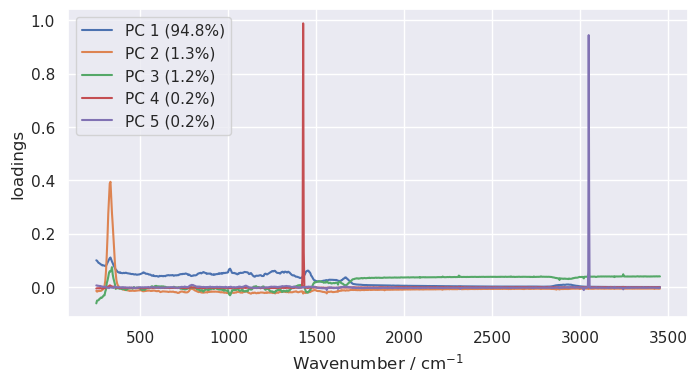

In [21]:
scan_pc_loadings = {list(scan_pc_labels.values())[i]: scan_pca_model.components_[i] for i in range(ncomp_plot)}
scan_pc_loadings["wn"] = scan_spec.x
pd.DataFrame(scan_pc_loadings).plot(x="wn", ylabel="loadings",
                               xlabel='Wavenumber / $\mathregular{cm^{-1}}$')

Plot PCA variance

<Axes: title={'center': 'PCA explained variance'}, xlabel='#PC', ylabel='Proportion'>

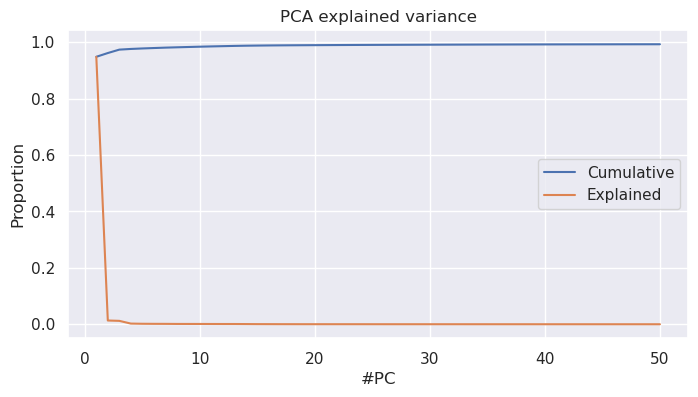

In [22]:
variance = scan_pca_model.explained_variance_ratio_
variance_df = pd.DataFrame({"#PC": np.arange(1, len(variance) + 1),
                            "Cumulative": variance.cumsum(),
                            "Explained": variance })
variance_df.plot(x='#PC', ylabel="Proportion",
                 title="PCA explained variance")

Plot clustering results for the scan

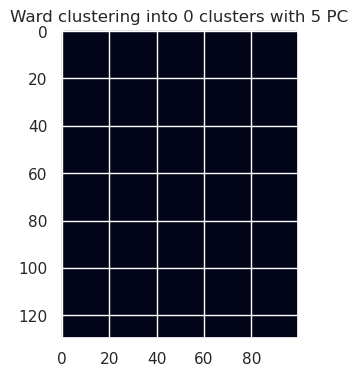

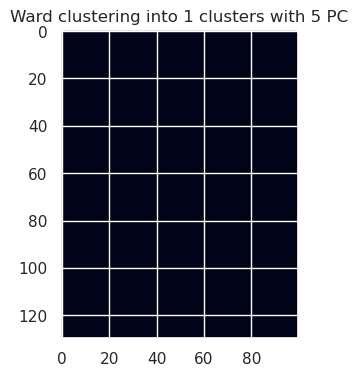

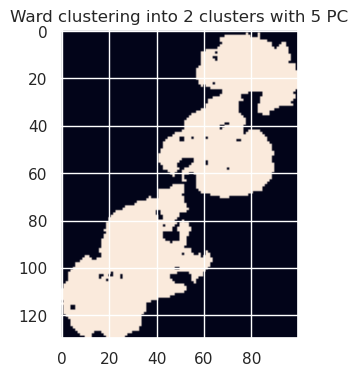

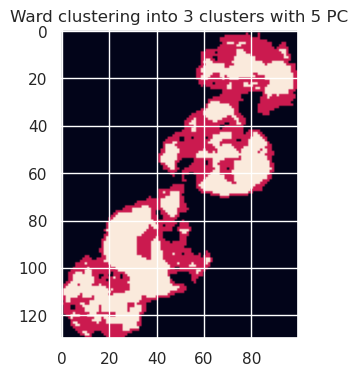

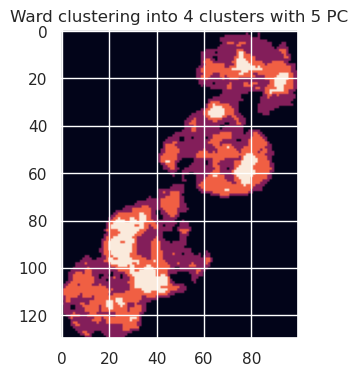

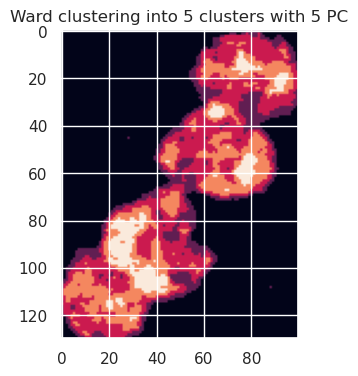

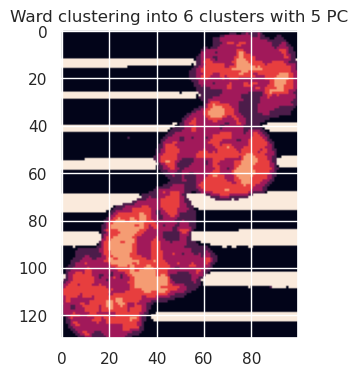

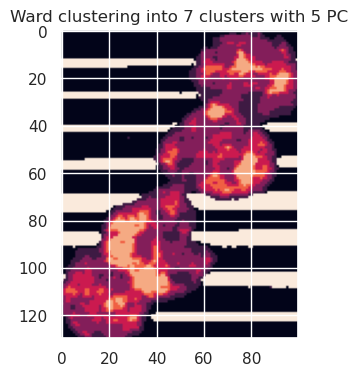

In [23]:
scan_hca_model = hierarchy.ward(scan_pc_mat[:, :ncomp_plot])
for n_clusters in range(8):
    hca_clusters = hierarchy.cut_tree(scan_hca_model, n_clusters=n_clusters)
    plt.imshow(hca_clusters.reshape(scan_shape))
    plt.title(f"Ward clustering into {n_clusters} clusters with {ncomp_plot} PC")
    plt.show()